# Check perturbation experiment output
Look at transport response to wind perturbation

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import subprocess

In [2]:
from glob import glob
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import numpy as np

## Read in model data

In [5]:
def open_model_data(path):
    # file list
    flist = (
        glob(f'{path}*20080101*vmo.nc') +
        glob(f'{path}*20080101*vo.nc') +
        glob(f'{path}*20080101*vo_g.nc') +
        glob(f'{path}*20080101*vo_bt.nc') +
        glob(f'{path}*20080101*volcello.nc')
    )
    
    # dmget files
    _ = subprocess.run(["dmget"]+flist, check=True)
    
    v2drop = ['average_DT', 'average_T1', 'average_T2','time_bnds']
    # open and clean up model data
    DS = xr.open_mfdataset(flist,use_cftime=True,combine='by_coords',engine='netcdf4',
                           drop_variables=v2drop)
    # Clean up coordinate names
    crds2chng = [match for match in list(DS.coords) if "_sub01" in match]
    for i in crds2chng:
        DS = DS.rename_dims({i:i[:2]}).rename({i:i[:2]})
        
    # dmget ocean static
    f_OS = path + '../../../ocean_Bering_Strait.static.nc'
    _ = subprocess.run(["dmget"]+[f_OS],check=True)
        
    # open the static file
    OS = xr.open_dataset(f_OS,engine='netcdf4')
    
    # assign geolat and geolon from ocean static
    DS = DS.assign_coords({'geolon_v':OS['geolon_v'].sel(xh=DS.xh,yq=DS.yq),
                           'geolat_v':OS['geolat_v'].sel(xh=DS.xh,yq=DS.yq)})
    
    # merge in static data
    DS = xr.merge([DS,
                   OS['areacello'].sel(xh=DS.xh,yh=DS.yh),
                   OS['areacello_cv'].sel(xh=DS.xh,yq=DS.yq),
                   OS['dxCv'].sel(xh=DS.xh,yq=DS.yq),
                   OS['dyCv'].sel(xh=DS.xh,yq=DS.yq)]).squeeze()
    
    # calc dz_v
    DS['dzCv'] = DS['volcello']/DS['areacello']
    
    # reference density
    rho_0 = 1035
    # total transport
    DS['T_vmo'] = DS['vmo'].sum(['xh','z_l'])/rho_0*(1e-6)
    # calc transports for each vo term
    terms = ['vo', 'vo_g', 'vo_bt']
    for term in terms:
        DS['T_' + term] = (1e-6 * DS[term] * DS.dzCv * DS.dxCv).sum(['xh','z_l'])
    
    # Lat, Lon, depth of mooring observations
    llz_moor = [66 + (19.6/60), -168 - (57.5/60) + 0.25, 57]
    # Cross-sectional area of strait [m^2]
    area_BS = 4.25e6
    # calc transport with mooring method
    DS['T_moor'] = DS['vo'].isel(
        xh=abs(DS.geolon_v - llz_moor[1]).argmin().values).sel(
        z_l=llz_moor[-1],method='nearest') * 1e-6 * area_BS
    
    return DS

def perturb_response(exp):
    # paths
    base = '/archive/Marion.Alberty/FMS2021.02_mom6_devgfdl_20221223/OM4p25_JRA55do1.4_0netfw_cde.02_'
    pp = '/gfdl.ncrc4-intel18-prod/pp/ocean_Bering_Strait/ts/daily/*yr/'
    pert = 'BWP_68.193_Lx300_Ly500_tau28_'
    ctrl = 'BWP_ctrl'
    # perturbation experiment path
    p_pert = base + pert + exp + pp
    # control path
    p_ctrl = base + ctrl + pp
    
    # get datasets
    DS = open_model_data(p_pert)
    CTRL = open_model_data(p_ctrl)
    
    # responses
    terms = [match for match in list(DS.keys()) if "T_" in match]
    for term in terms:
        DS[term + '_r'] = DS[term] - CTRL[term]
    
    # means and stds
    terms = [match for match in list(DS.keys()) if "_r" in match]
    for term in terms:
        DS[term + '_bar'] = DS[term].sel(
            time=slice('2008-04-01','2008-12-31')).mean('time')
        DS[term + '_std'] = DS[term].sel(
            time=slice('2008-04-01','2008-12-31')).std('time')
    
    
    return DS

## Set model paths

In [6]:
DS_v0 = perturb_response('v0')
DS_v1 = perturb_response('v1')
DS_v2 = perturb_response('v2.5')
DS_v5 = perturb_response('v5')
DS_v10 = perturb_response('v10')
DS_v20 = perturb_response('v20')

## Look at transport differences

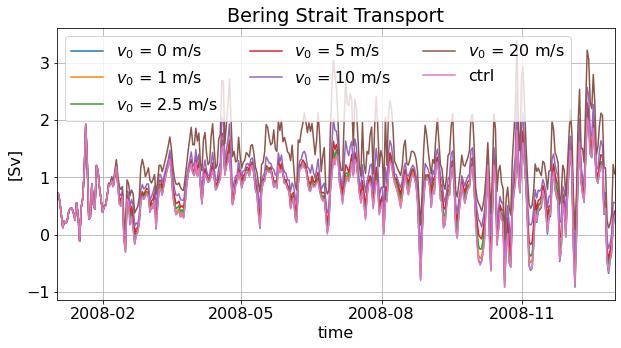

In [8]:
fig = plt.figure(figsize=(10,5))
DS_v0['T_vmo'].plot(label='$v_0$ = 0 m/s')
DS_v1['T_vmo'].plot(label='$v_0$ = 1 m/s')
DS_v2['T_vmo'].plot(label='$v_0$ = 2.5 m/s')
DS_v5['T_vmo'].plot(label='$v_0$ = 5 m/s')
DS_v10['T_vmo'].plot(label='$v_0$ = 10 m/s')
DS_v20['T_vmo'].plot(label='$v_0$ = 20 m/s')
(DS_v0['T_vmo']- DS_v0['T_vmo_r']).plot(label='ctrl')
plt.title('Bering Strait Transport')
plt.ylabel('[Sv]')
plt.legend(ncol=3)
plt.grid()
plt.xlim(DS_v0.time[0].values,DS_v0.time[-1].values)
plt.show()

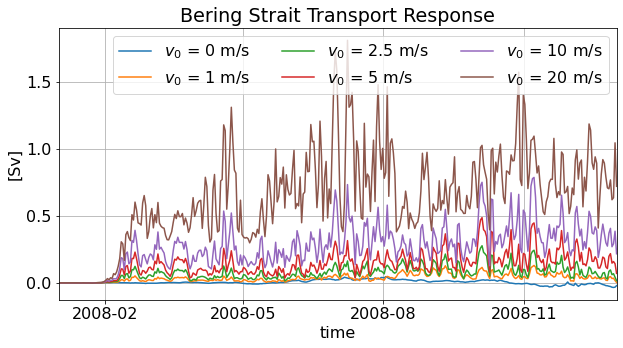

In [9]:
fig = plt.figure(figsize=(10,5))
DS_v0['T_vmo_r'].plot(label='$v_0$ = 0 m/s')
DS_v1['T_vmo_r'].plot(label='$v_0$ = 1 m/s')
DS_v2['T_vmo_r'].plot(label='$v_0$ = 2.5 m/s')
DS_v5['T_vmo_r'].plot(label='$v_0$ = 5 m/s')
DS_v10['T_vmo_r'].plot(label='$v_0$ = 10 m/s')
DS_v20['T_vmo_r'].plot(label='$v_0$ = 20 m/s')
plt.title('Bering Strait Transport Response')
plt.ylabel('[Sv]')
plt.legend(ncol=3)
plt.grid()
plt.xlim(DS_v0.time[0].values,DS_v0.time[-1].values)
plt.show()

## Compare time average of response to forcing strength

In [ ]:
def mean_transport_response(DS):
    T_bar = (DS['vmo'].sum(['xh','z_l']) - DS_ctrl['vmo'].sum(['xh','z_l'])
            ).sel(time=slice('1958-04-01',None)).mean('time')/rho_0*(10**-6)
    return T_bar.values

In [ ]:
def mean_mooring_response(DS):
    T_bar = (DS['vo'] - DS_ctrl['vo']).isel(xh=abs(DS_ctrl.geolon_v - llz_moor[1]).argmin().values
                                               ).sel(z_l=llz_moor[-1],method='nearest'
                                                    ).sel(time=slice('1958-04-01',None)
                                                         ).mean('time')* 1e-6 * area_BS
    return T_bar.values

In [ ]:
def std_transport_response(DS):
    T_std = (DS['vmo'].sum(['xh','z_l']) - DS_ctrl['vmo'].sum(['xh','z_l'])
            ).sel(time=slice('1958-04-01',None)).std('time')/rho_0*(10**-6)
    return T_std.values

In [ ]:
def std_mooring_response(DS):
    T_std = (DS['vo'] - DS_ctrl['vo']).isel(xh=abs(DS_ctrl.geolon_v - llz_moor[1]).argmin().values
                                               ).sel(z_l=llz_moor[-1],method='nearest'
                                                    ).sel(time=slice('1958-04-01',None)
                                                         ).std('time')* 1e-6 * area_BS
    return T_std.values

In [10]:
T = [DS_v0['T_vmo_r_bar'].values,
     DS_v1['T_vmo_r_bar'].values,
     DS_v2['T_vmo_r_bar'].values,
     DS_v5['T_vmo_r_bar'].values,
     DS_v10['T_vmo_r_bar'].values,
     DS_v20['T_vmo_r_bar'].values]
Tm = [DS_v0['T_moor_r_bar'].values,
      DS_v1['T_moor_r_bar'].values,
      DS_v2['T_moor_r_bar'].values,
      DS_v5['T_moor_r_bar'].values,
      DS_v10['T_moor_r_bar'].values,
      DS_v20['T_moor_r_bar'].values]
T_std = [DS_v0['T_vmo_r_std'].values,
         DS_v1['T_vmo_r_std'].values,
         DS_v2['T_vmo_r_std'].values,
         DS_v5['T_vmo_r_std'].values,
         DS_v10['T_vmo_r_std'].values,
         DS_v20['T_vmo_r_std'].values]
Tm_std = [DS_v0['T_moor_r_std'].values,
          DS_v1['T_moor_r_std'].values,
          DS_v2['T_moor_r_std'].values,
          DS_v5['T_moor_r_std'].values,
          DS_v10['T_moor_r_std'].values,
          DS_v20['T_moor_r_std'].values]
vas = [0, 1, 2.5, 5, 10, 20]

In [11]:
p = np.polyfit(vas,T,1,full=True)
pm = np.polyfit(vas,Tm,1,full=True)

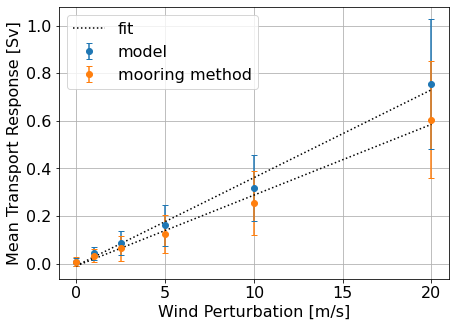

In [12]:
fig = plt.figure(figsize=(7,5))
plt.errorbar(vas,T,yerr=T_std,fmt='o',label='model',capsize=3)
plt.errorbar(vas,Tm,yerr=Tm_std,fmt='o',label='mooring method',capsize=3)
plt.plot(vas,np.polyval(p[0],vas),':k',label='fit')
plt.plot(vas,np.polyval(pm[0],vas),':k')
plt.ylabel('Mean Transport Response [Sv]')
plt.xlabel('Wind Perturbation [m/s]')
plt.legend()
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/PerturbationExperiments/BStransportResponse_perWindPert.pdf',bbox_inches='tight')

In [13]:
print('A 0.266 Sv increase in transport would require a %.2f m/s vas perturbation.' %((0.266 - p[0][1])/p[0][0]))

A 0.266 Sv increase in transport would require a 7.43 m/s vas perturbation.


In [14]:
print('A 0.266 Sv increase in transport would require a %.2f m/s vas perturbation.' %((0.266 - pm[0][1])/pm[0][0]))

A 0.266 Sv increase in transport would require a 9.28 m/s vas perturbation.


## Breakdown the response into a geostrophic responce

In [19]:
# geostrophic
Tg = [DS_v0['T_vo_g_r_bar'].values,
      DS_v1['T_vo_g_r_bar'].values,
      DS_v2['T_vo_g_r_bar'].values,
      DS_v5['T_vo_g_r_bar'].values,
      DS_v10['T_vo_g_r_bar'].values,
      DS_v20['T_vo_g_r_bar'].values]
Tg_std = [DS_v0['T_vo_g_r_std'].values,
          DS_v1['T_vo_g_r_std'].values,
          DS_v2['T_vo_g_r_std'].values,
          DS_v5['T_vo_g_r_std'].values,
          DS_v10['T_vo_g_r_std'].values,
          DS_v20['T_vo_g_r_std'].values]
# barotropic
Tb = [DS_v0['T_vo_bt_r_bar'].values,
      DS_v1['T_vo_bt_r_bar'].values,
      DS_v2['T_vo_bt_r_bar'].values,
      DS_v5['T_vo_bt_r_bar'].values,
      DS_v10['T_vo_bt_r_bar'].values,
      DS_v20['T_vo_bt_r_bar'].values]
Tb_std = [DS_v0['T_vo_bt_r_std'].values,
          DS_v1['T_vo_bt_r_std'].values,
          DS_v2['T_vo_bt_r_std'].values,
          DS_v5['T_vo_bt_r_std'].values,
          DS_v10['T_vo_bt_r_std'].values,
          DS_v20['T_vo_bt_r_std'].values]

In [20]:
pg = np.polyfit(vas,Tg,1,full=True)
pb = np.polyfit(vas,Tb,1,full=True)

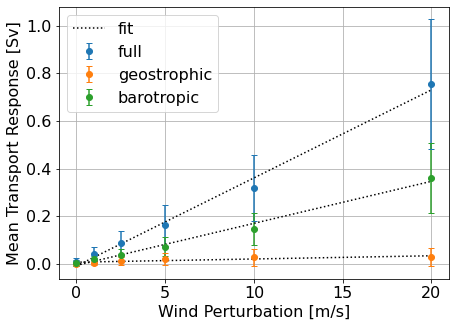

In [22]:
fig = plt.figure(figsize=(7,5))
plt.errorbar(vas,T,yerr=T_std,fmt='o',label='full',capsize=3)
plt.errorbar(vas,Tg,yerr=Tg_std,fmt='o',label='geostrophic',capsize=3)
plt.errorbar(vas,Tb,yerr=Tb_std,fmt='o',label='barotropic',capsize=3)
plt.plot(vas,np.polyval(p[0],vas),':k',label='fit')
plt.plot(vas,np.polyval(pg[0],vas),':k')
plt.plot(vas,np.polyval(pb[0],vas),':k')
plt.ylabel('Mean Transport Response [Sv]')
plt.xlabel('Wind Perturbation [m/s]')
plt.legend()
plt.grid()
plt.show()
# save fig
fig.savefig('../figures/PerturbationExperiments/BStransportResponse_perWindPert_geoBaro.pdf',bbox_inches='tight')

## Make some simple plots of departures from the control

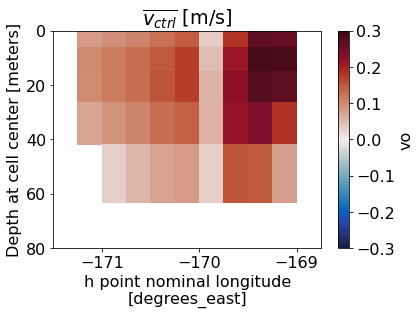

In [22]:
DS_ctrl['vo'].mean('time').plot(yincrease=False,cmap='cmo.balance',vmin=-0.3,vmax=0.3)
plt.title(r'$\overline{v_{ctrl}}$ [m/s')
plt.ylim(80,0)
plt.show()

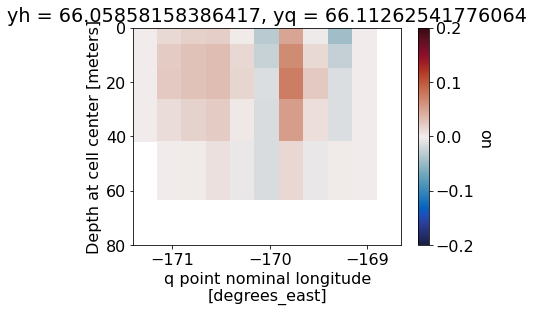

In [19]:
DS_ctrl['uo'].mean('time').plot(yincrease=False,cmap='cmo.balance',vmin=-0.2,vmax=0.2)
plt.ylim(80,0)
plt.show()

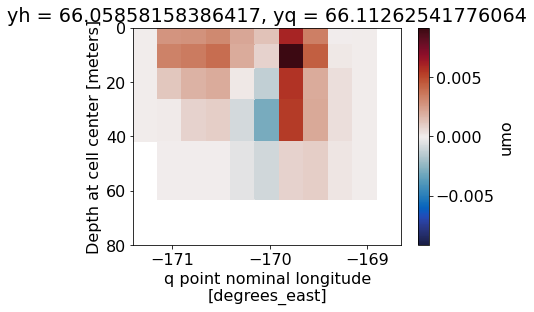

In [20]:
((DS_v20['umo'].mean('time') - DS_ctrl['umo'].mean('time'))*1e-6/1035).plot(yincrease=False,cmap='cmo.balance')
plt.ylim(80,0)
plt.show()

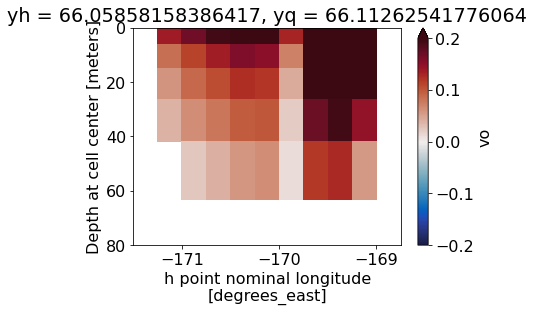

In [21]:
(DS_v20['vo'].mean('time') - DS_ctrl['vo'].mean('time')).plot(yincrease=False,cmap='cmo.balance',
                                                                     vmin=-0.2,vmax=0.2)
plt.ylim(80,0)
plt.show()

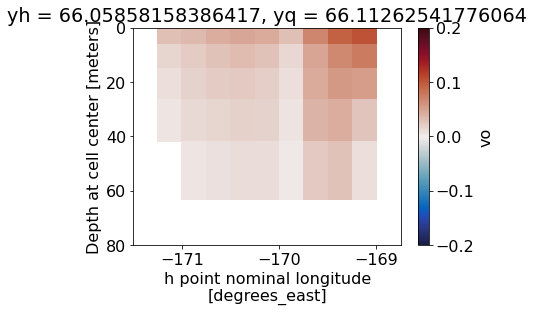

In [22]:
(DS_v5['vo'].mean('time') - DS_ctrl['vo'].mean('time')).plot(yincrease=False,cmap='cmo.balance',
                                                                     vmin=-0.2,vmax=0.2)
plt.ylim(80,0)
plt.show()

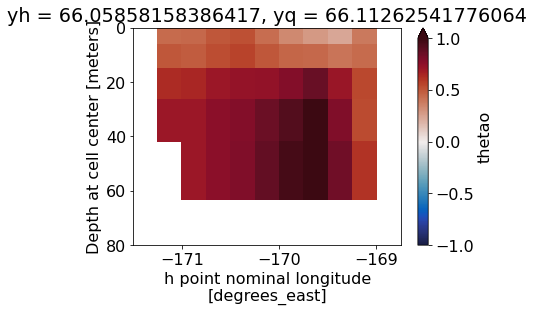

In [23]:
(DS_v20['thetao'].mean('time') - DS_ctrl['thetao'].mean('time')).plot(yincrease=False,cmap='cmo.balance',
                                                                     vmin=-1,vmax=1)
plt.ylim(80,0)
plt.show()

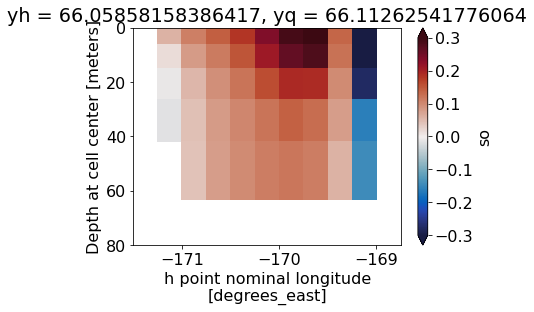

In [24]:
(DS_v20['so'].mean('time') - DS_ctrl['so'].mean('time')).plot(yincrease=False,cmap='cmo.balance',
                                                                     vmin=-0.3,vmax=0.3)
plt.ylim(80,0)
plt.show()